# Model Comparison & Analysis

Compare all trained models (CAE, VAE, Denoising AE) on MVTec AD dataset.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.insert(0, 'F:/Thesis')

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.metrics import roc_auc_score, roc_curve

from src.config import DEVICE, MODELS_DIR, FIGURES_DIR, OUTPUTS_DIR, MVTEC_CATEGORIES, ensure_dirs
from src.data import MVTecDataset, create_mvtec_dataloaders
from src.models import create_cae, create_vae, create_denoising_ae

ensure_dirs()
print(f"Device: {DEVICE}")

Device: cpu


## 1. Load All Results from CSV Files

In [2]:
# Load saved results from training runs
results = {}

# CAE results
cae_csv = OUTPUTS_DIR / 'cae_mvtec_results.csv'
if cae_csv.exists():
    results['CAE'] = pd.read_csv(cae_csv)
    print(f"Loaded CAE results: {len(results['CAE'])} categories")

# VAE results
vae_csv = OUTPUTS_DIR / 'vae_mvtec_results.csv'
if vae_csv.exists():
    results['VAE'] = pd.read_csv(vae_csv)
    print(f"Loaded VAE results: {len(results['VAE'])} categories")

# DAE results
dae_csv = OUTPUTS_DIR / 'dae_mvtec_results.csv'
if dae_csv.exists():
    results['DAE'] = pd.read_csv(dae_csv)
    print(f"Loaded DAE results: {len(results['DAE'])} categories")

print(f"\nModels loaded: {list(results.keys())}")

Loaded VAE results: 15 categories
Loaded DAE results: 15 categories

Models loaded: ['VAE', 'DAE']


## 2. Combined Results Table

In [3]:
# Merge all results into one comparison table
if results:
    comparison = pd.DataFrame({'category': MVTEC_CATEGORIES})
    
    for name, df in results.items():
        df_renamed = df[['category', 'auc']].rename(columns={'auc': f'{name}_AUC'})
        comparison = comparison.merge(df_renamed, on='category', how='left')
    
    # Display
    display(comparison.style.format({col: '{:.4f}' for col in comparison.columns if 'AUC' in col})
                              .background_gradient(subset=[c for c in comparison.columns if 'AUC' in c], cmap='RdYlGn'))
    
    # Save
    comparison.to_csv(OUTPUTS_DIR / 'model_comparison.csv', index=False)
    print("\nSaved to: outputs/model_comparison.csv")

,category,VAE_AUC,DAE_AUC
0,bottle,0.4571,0.5373
1,cable,0.4025,0.4644
2,capsule,0.5895,0.4659
3,carpet,0.2504,0.3319
4,grid,0.4996,0.8697
5,hazelnut,0.3261,0.8879
6,leather,0.2385,0.3886
7,metal_nut,0.6725,0.2683
8,pill,0.4081,0.7621
9,screw,1.0000,0.9859



Saved to: outputs/model_comparison.csv


## 3. Per-Category Bar Chart Comparison

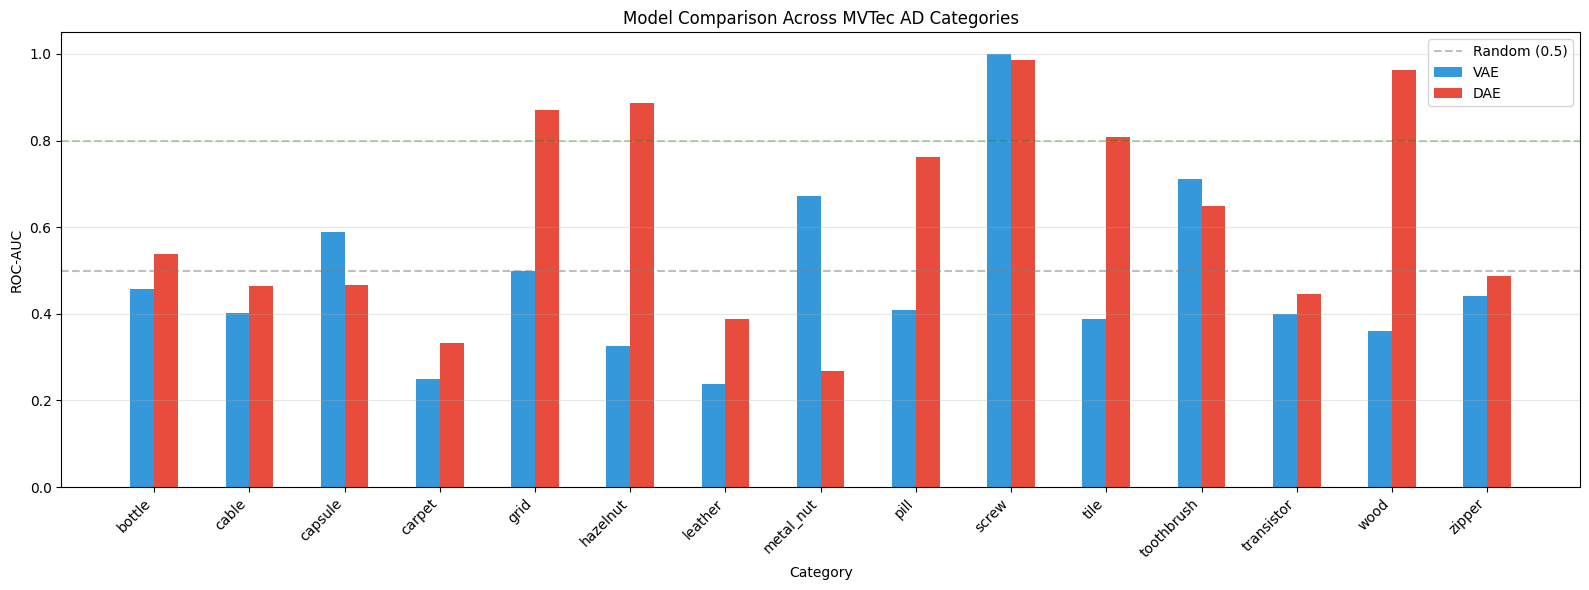

In [4]:
if results:
    fig, ax = plt.subplots(figsize=(16, 6))
    
    x = np.arange(len(MVTEC_CATEGORIES))
    width = 0.25
    colors = {'CAE': '#2ecc71', 'VAE': '#3498db', 'DAE': '#e74c3c'}
    
    for i, (name, df) in enumerate(results.items()):
        # Align by category
        aucs = []
        for cat in MVTEC_CATEGORIES:
            val = df[df['category'] == cat]['auc'].values
            aucs.append(val[0] if len(val) > 0 else 0)
        
        offset = (i - len(results)/2 + 0.5) * width
        ax.bar(x + offset, aucs, width, label=name, color=colors.get(name, 'gray'))
    
    ax.axhline(0.5, color='gray', linestyle='--', alpha=0.5, label='Random (0.5)')
    ax.axhline(0.8, color='green', linestyle='--', alpha=0.3)
    
    ax.set_xlabel('Category')
    ax.set_ylabel('ROC-AUC')
    ax.set_title('Model Comparison Across MVTec AD Categories')
    ax.set_xticks(x)
    ax.set_xticklabels(MVTEC_CATEGORIES, rotation=45, ha='right')
    ax.legend()
    ax.set_ylim(0, 1.05)
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / 'model_comparison_bar.png', dpi=150)
    plt.show()

## 4. Average Performance Summary

,Model,Mean AUC,Std AUC,Min AUC,Max AUC,Categories > 0.7,Categories > 0.5
0,VAE,0.476342,0.198252,0.238451,1.000000,2,4
1,DAE,0.620953,0.239744,0.268328,0.985858,6,8


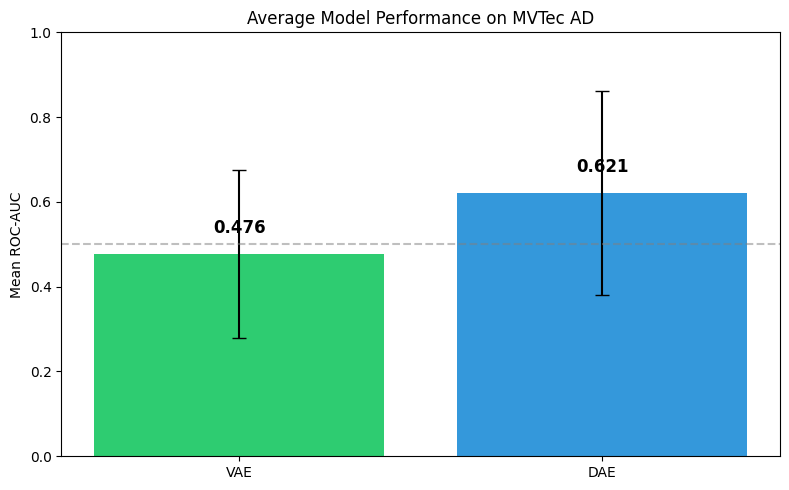

In [5]:
if results:
    summary = []
    for name, df in results.items():
        valid_aucs = df['auc'][df['auc'] > 0]  # Filter invalid results
        summary.append({
            'Model': name,
            'Mean AUC': valid_aucs.mean(),
            'Std AUC': valid_aucs.std(),
            'Min AUC': valid_aucs.min(),
            'Max AUC': valid_aucs.max(),
            'Categories > 0.7': (valid_aucs > 0.7).sum(),
            'Categories > 0.5': (valid_aucs > 0.5).sum(),
        })
    
    df_summary = pd.DataFrame(summary)
    display(df_summary)
    
    # Bar chart of mean AUC
    fig, ax = plt.subplots(figsize=(8, 5))
    colors = ['#2ecc71', '#3498db', '#e74c3c']
    bars = ax.bar(df_summary['Model'], df_summary['Mean AUC'], 
                  yerr=df_summary['Std AUC'], capsize=5, color=colors[:len(df_summary)])
    ax.axhline(0.5, color='gray', linestyle='--', alpha=0.5)
    ax.set_ylabel('Mean ROC-AUC')
    ax.set_title('Average Model Performance on MVTec AD')
    ax.set_ylim(0, 1)
    
    # Add value labels
    for bar, val in zip(bars, df_summary['Mean AUC']):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05, 
                f'{val:.3f}', ha='center', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / 'model_mean_comparison.png', dpi=150)
    plt.show()

## 5. Best Model Per Category

In [6]:
if len(results) > 1:
    best_models = []
    for cat in MVTEC_CATEGORIES:
        best_name, best_auc = None, 0
        for name, df in results.items():
            val = df[df['category'] == cat]['auc'].values
            if len(val) > 0 and val[0] > best_auc:
                best_auc = val[0]
                best_name = name
        best_models.append({'category': cat, 'best_model': best_name, 'auc': best_auc})
    
    df_best = pd.DataFrame(best_models)
    print("Best Model Per Category:")
    display(df_best)
    
    # Count wins
    wins = df_best['best_model'].value_counts()
    print(f"\nModel Wins: {dict(wins)}")

Best Model Per Category:


,category,best_model,auc
0,bottle,DAE,0.537302
1,cable,DAE,0.464393
2,capsule,VAE,0.589549
3,carpet,DAE,0.331862
4,grid,DAE,0.869674
5,hazelnut,DAE,0.887857
6,leather,DAE,0.388587
7,metal_nut,VAE,0.672532
8,pill,DAE,0.762139
9,screw,VAE,1.000000



Model Wins: {'DAE': np.int64(11), 'VAE': np.int64(4)}


## 6. Heatmap: Model × Category

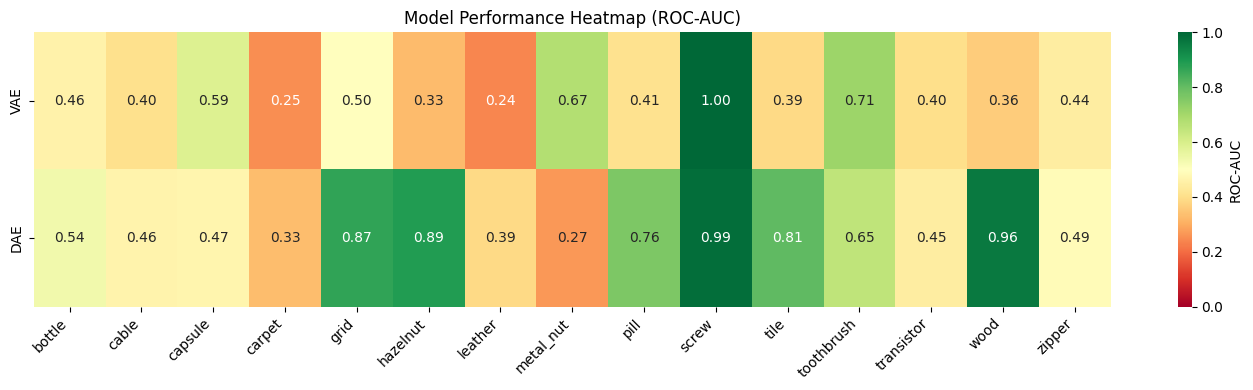

In [7]:
if results:
    # Create matrix
    matrix = []
    for name, df in results.items():
        row = []
        for cat in MVTEC_CATEGORIES:
            val = df[df['category'] == cat]['auc'].values
            row.append(val[0] if len(val) > 0 else np.nan)
        matrix.append(row)
    
    matrix = np.array(matrix)
    
    fig, ax = plt.subplots(figsize=(14, 4))
    sns.heatmap(matrix, annot=True, fmt='.2f', cmap='RdYlGn',
                xticklabels=MVTEC_CATEGORIES, yticklabels=list(results.keys()),
                vmin=0, vmax=1, ax=ax, cbar_kws={'label': 'ROC-AUC'})
    ax.set_title('Model Performance Heatmap (ROC-AUC)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / 'model_heatmap.png', dpi=150)
    plt.show()

## 7. Print Summary for Thesis

In [8]:
print("="*60)
print("THESIS SUMMARY")
print("="*60)

if results:
    for name, df in results.items():
        valid = df['auc'][df['auc'] > 0]
        print(f"\n{name}:")
        print(f"  Mean AUC: {valid.mean():.4f} ± {valid.std():.4f}")
        print(f"  Best: {df.loc[valid.idxmax(), 'category']} ({valid.max():.4f})")
        print(f"  Worst: {df.loc[valid.idxmin(), 'category']} ({valid.min():.4f})")

print("\n" + "="*60)
print("Generated Figures:")
for f in sorted(FIGURES_DIR.glob('*.png')):
    print(f"  - {f.name}")

THESIS SUMMARY

VAE:
  Mean AUC: 0.4763 ± 0.1983
  Best: screw (1.0000)
  Worst: leather (0.2385)

DAE:
  Mean AUC: 0.6210 ± 0.2397
  Best: screw (0.9859)
  Worst: metal_nut (0.2683)

Generated Figures:
  - cae_bottle_loss_curve.png
  - cae_bottle_reconstruction.png
  - cae_bottle_reconstructions.png
  - cae_bottle_roc_curve.png
  - cae_bottle_train_samples.png
  - cae_bottle_training.png
  - cae_cable_reconstruction.png
  - cae_cable_training.png
  - cae_capsule_reconstruction.png
  - cae_capsule_training.png
  - cae_carpet_reconstruction.png
  - cae_carpet_training.png
  - cae_grid_reconstruction.png
  - cae_grid_training.png
  - cae_hazelnut_reconstruction.png
  - cae_hazelnut_training.png
  - cae_leather_reconstruction.png
  - cae_leather_training.png
  - cae_metal_nut_reconstruction.png
  - cae_metal_nut_training.png
  - cae_pill_reconstruction.png
  - cae_pill_training.png
  - cae_screw_reconstruction.png
  - cae_screw_training.png
  - cae_tile_reconstruction.png
  - cae_tile_tra